## Counting Bloom Filters

### Review
A Counting Bloom Filter is an extension of a traditional Bloom Filter. Let's quickly recap on what a Bloom Filter is.

Bloom Filters are randomised data structures which can be used to check whether:
- an element is definitely not in a set
- an element is possibly in a set 

The reason we cannot know if an element if definitely in a set, is because of overlaps in pointers. An element may hash to 3 slots which are assigned 1s, but they may have been assigned 1s because of other elements. For example, below, elements A and B are both in the set, but if we query for element C, which is *not* in the set, the bloom filter will return true, the element *may* be in the set. It is clear that bloom filters allow for *false positives*

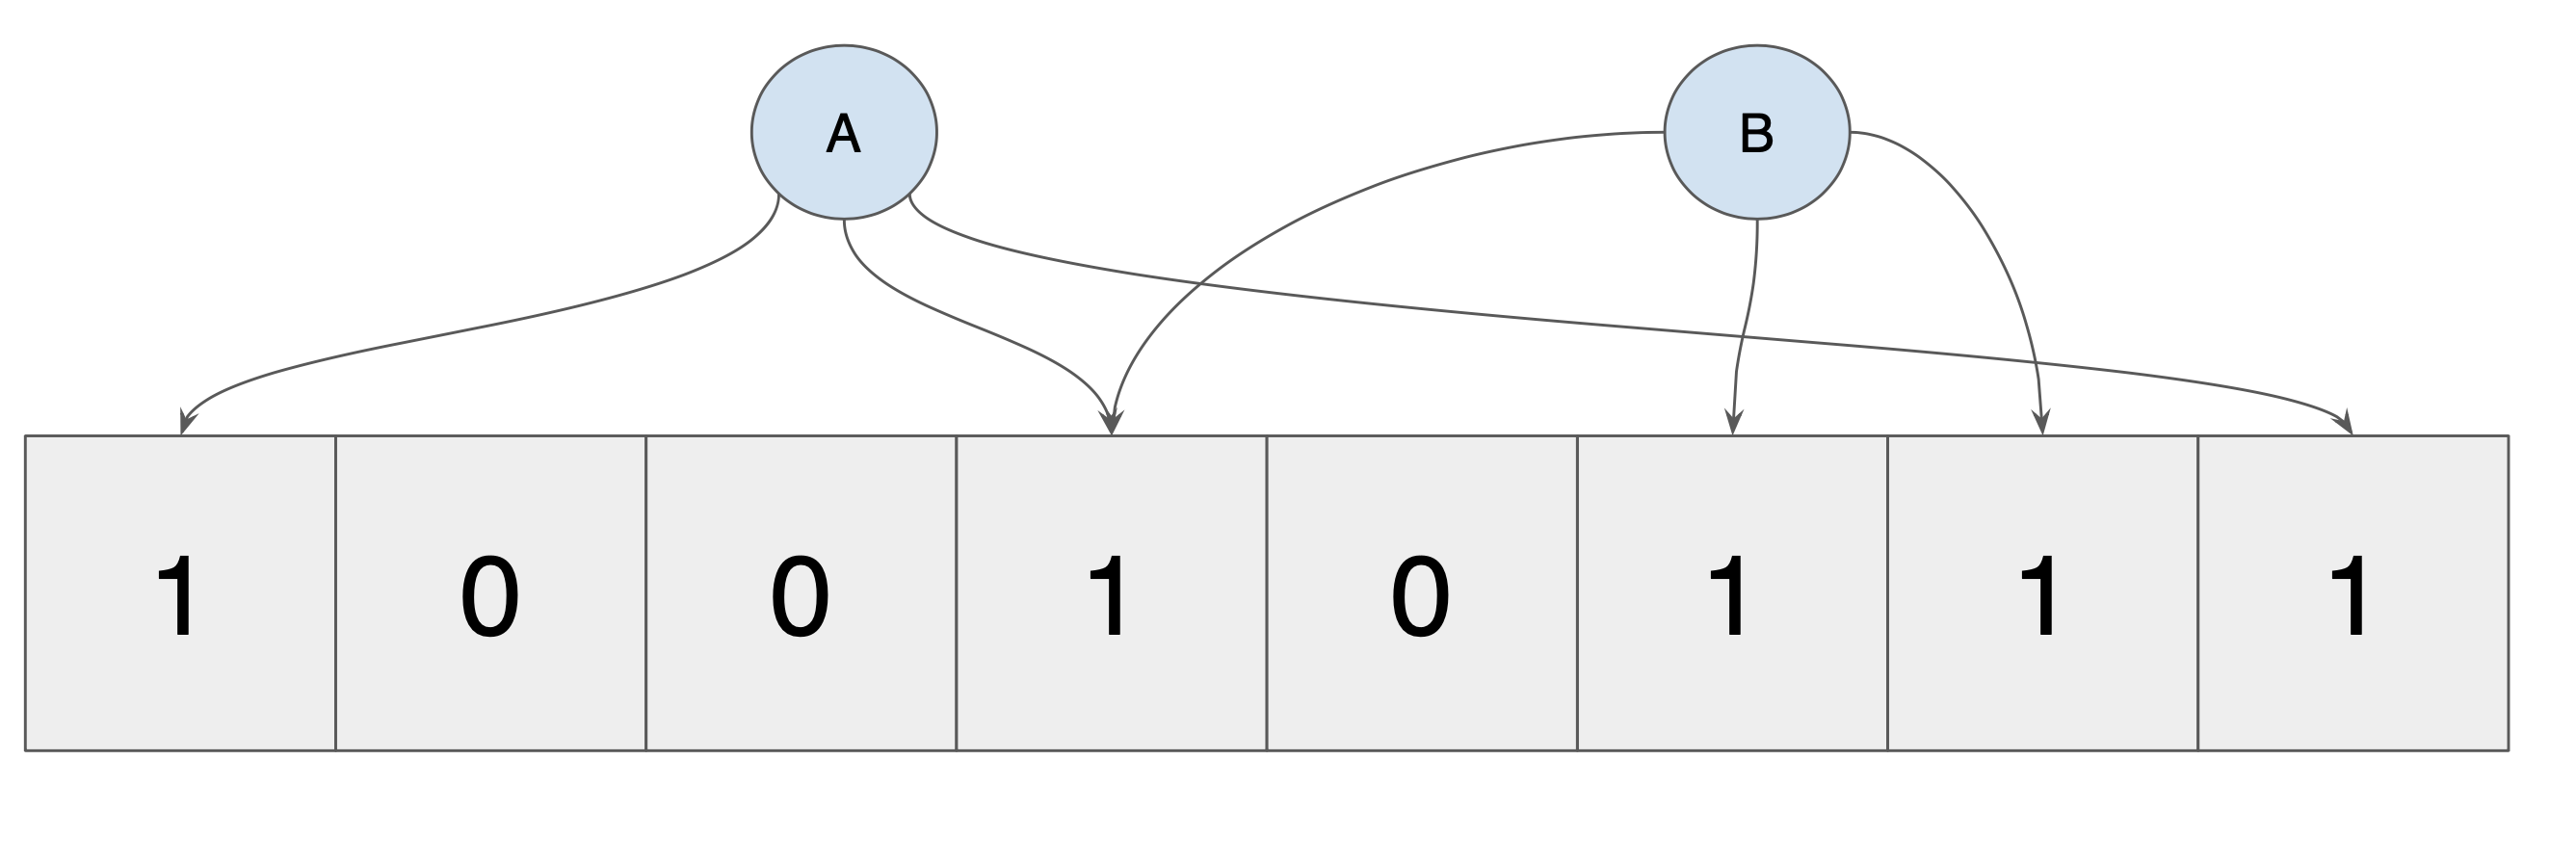

In [585]:
from IPython.display import Image
Image(filename='first.jpg')

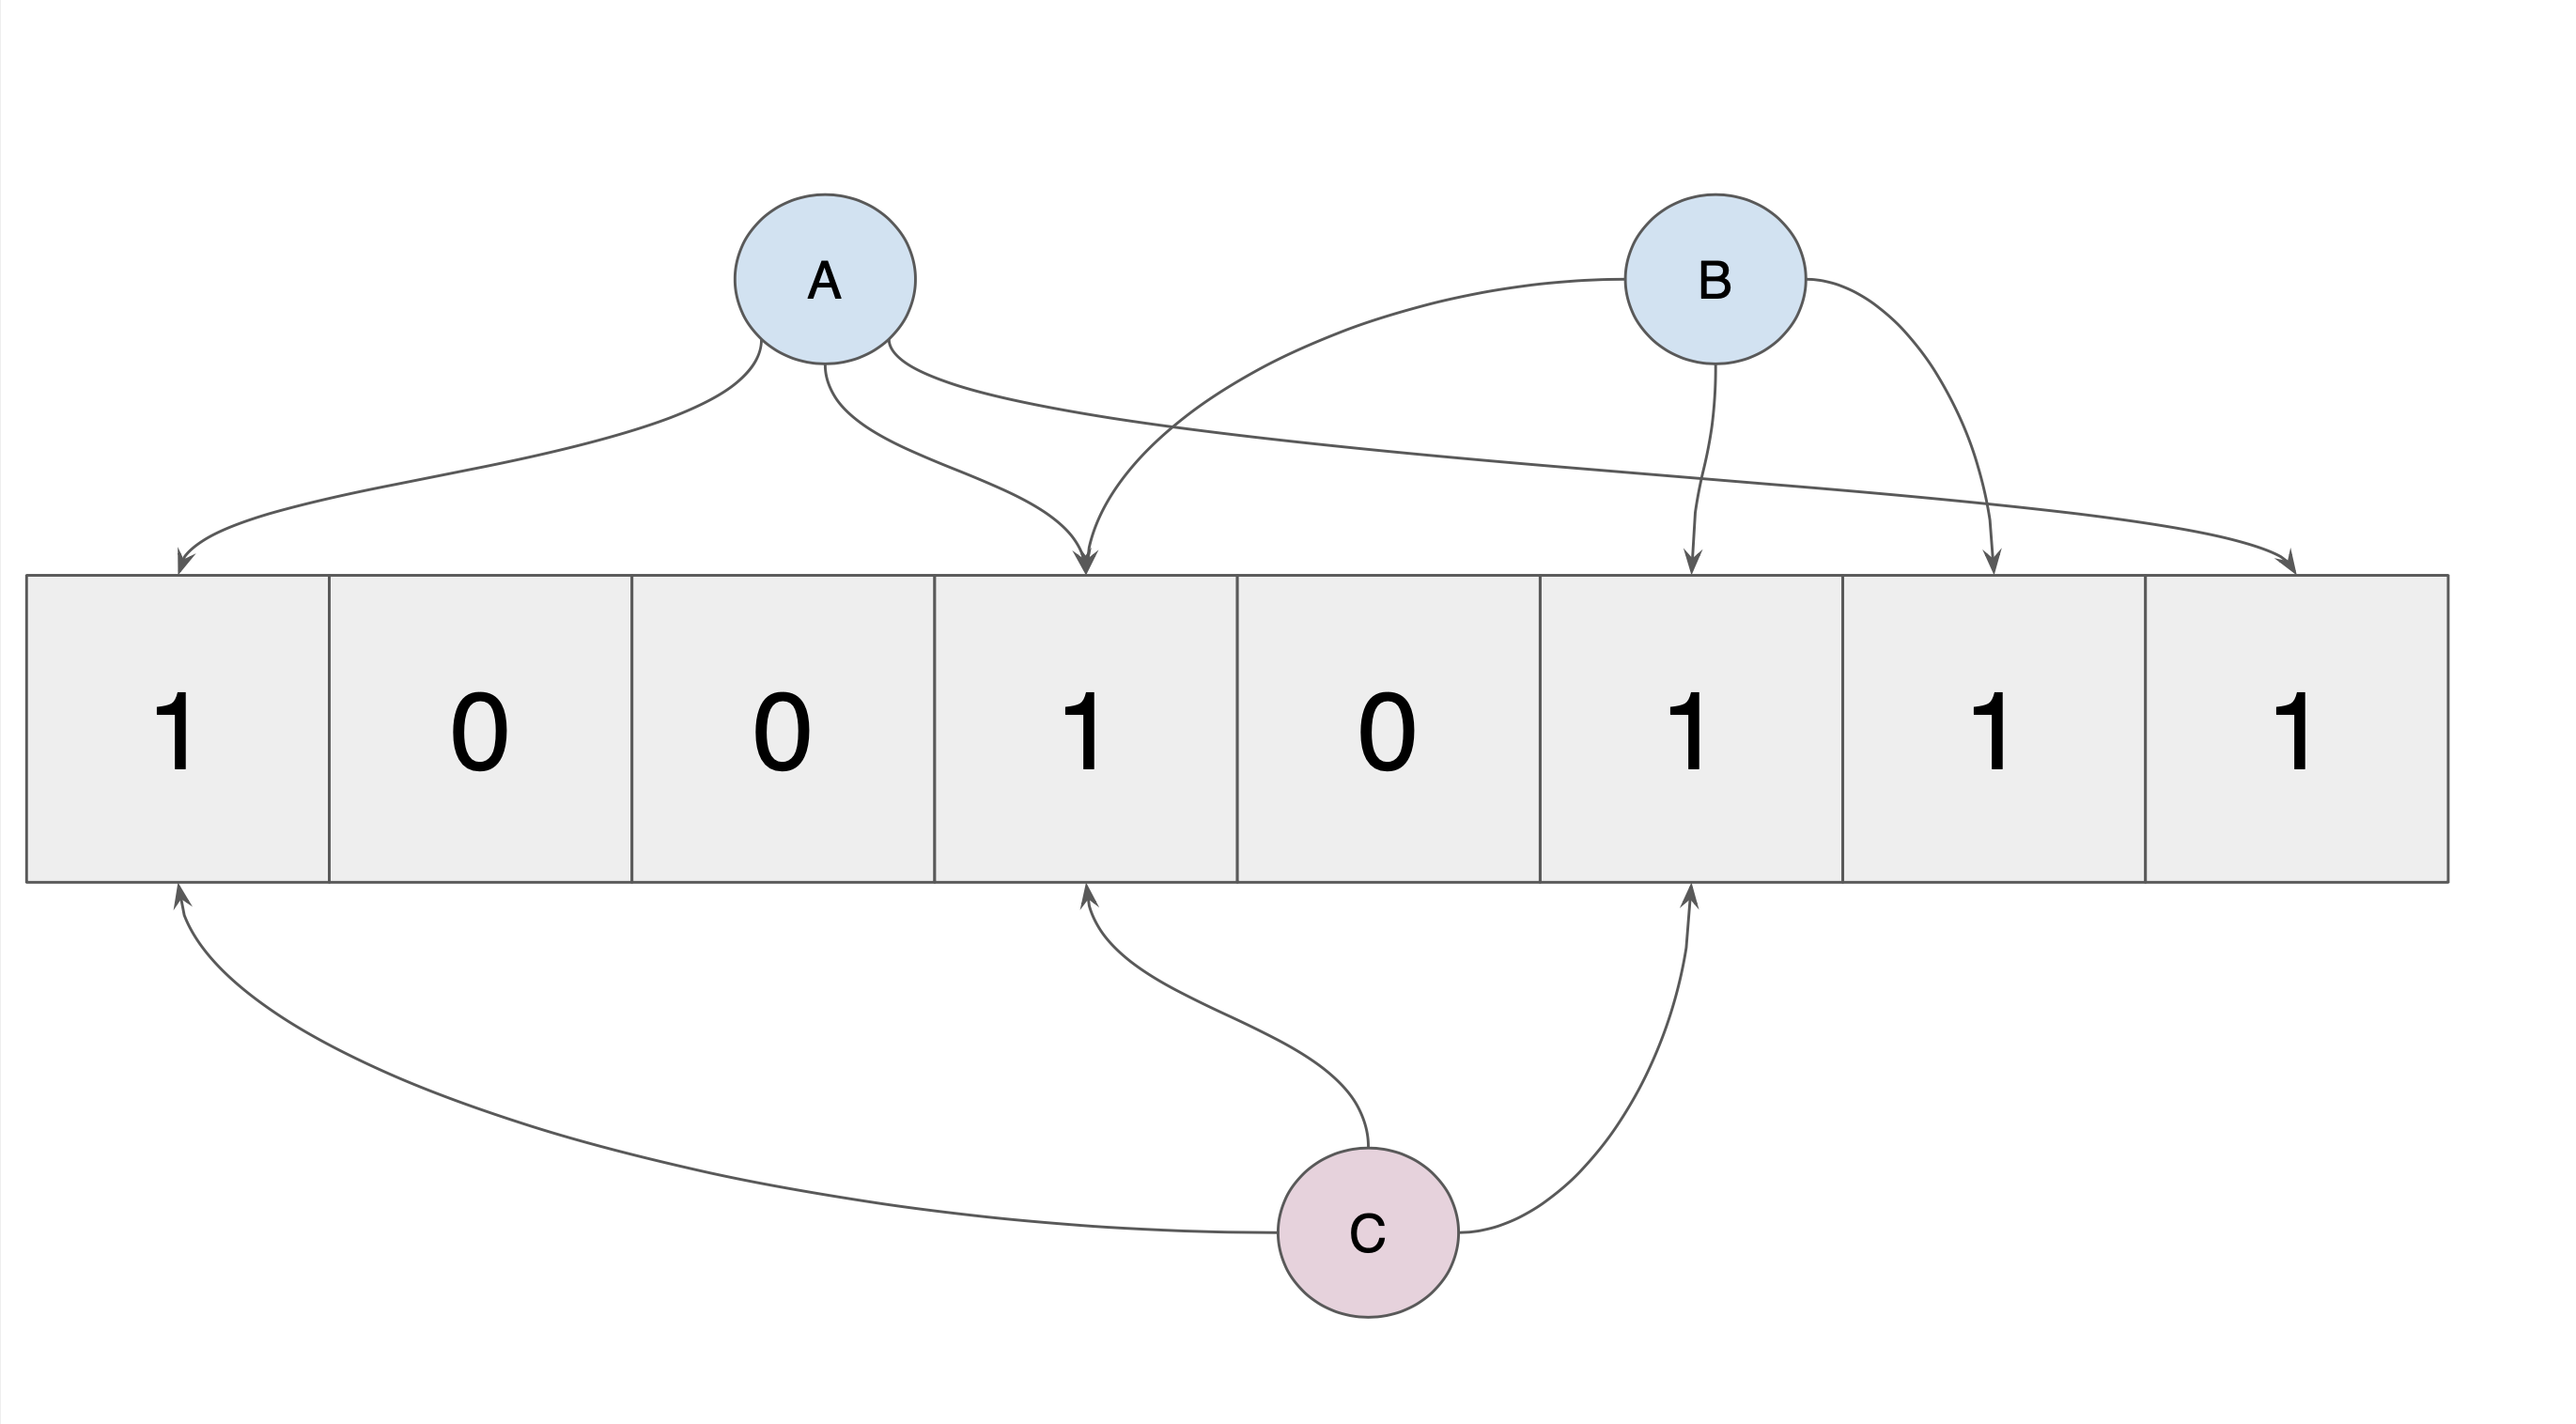

In [12]:
Image(filename='second.jpg')

With traditional Bloom Filters, deletion is impossible. This is because if we revert the bits in the bit array which correspond to a specific value to zero, we may be revert a bit which corresponds to another value to zero, and hence that value with not be able to be queried. In our example, if we delete element A, one of the pointers necessary for querying element B is deleted and hence, the bloom filter would wrongly return that element B is not in the set.


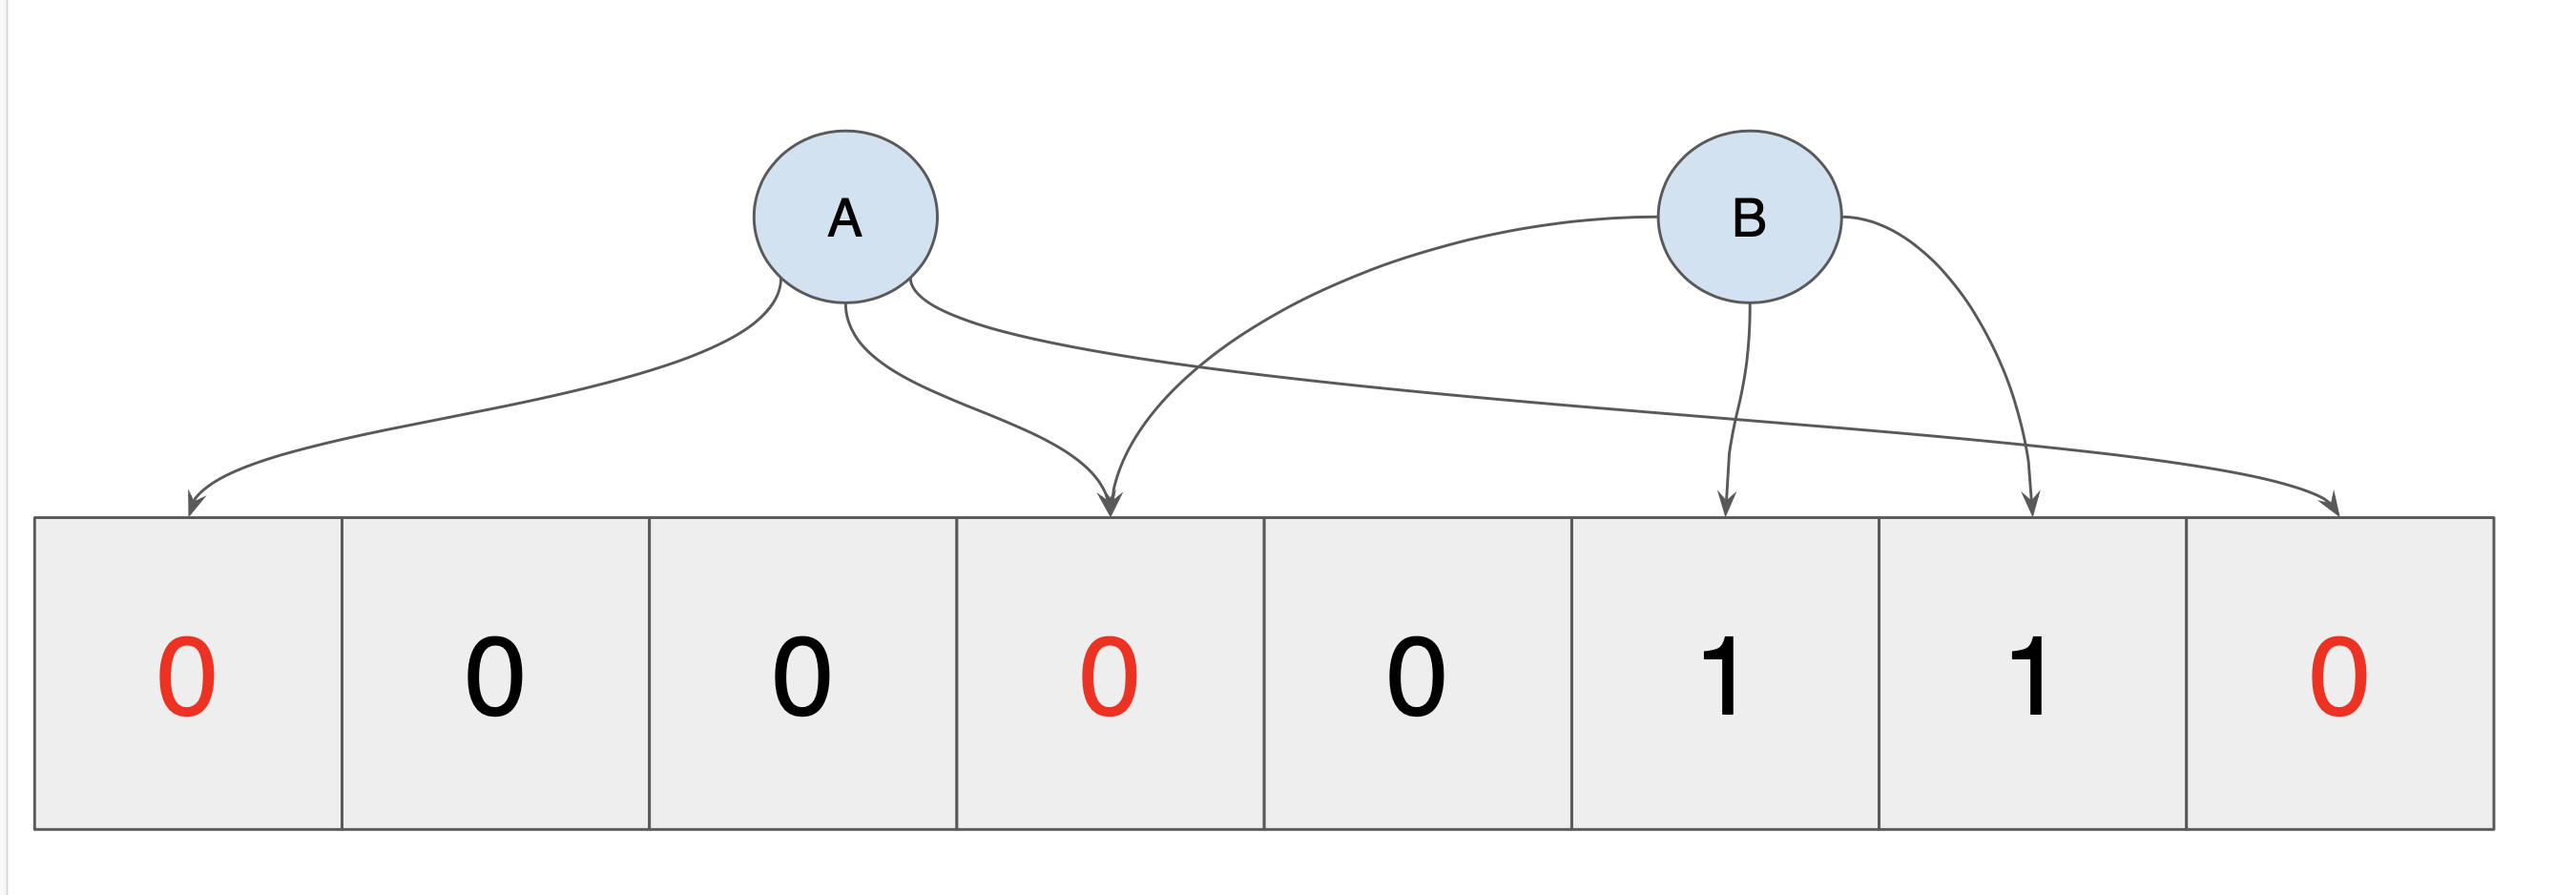

In [13]:
Image(filename='third.jpg')

### Solving the problem of Bloom Filters
Counting Bloom Filters solve this problem and allow us to *add*, *query*, and *delete* an element.

Instead of only allowing a single bit (zero or one) in each slot, Counting Bloom Filters allow us to increment each hashed slot by 1 when an element is added there. Conversely, when an item is deleted, the hashed slots are decremented by 1.

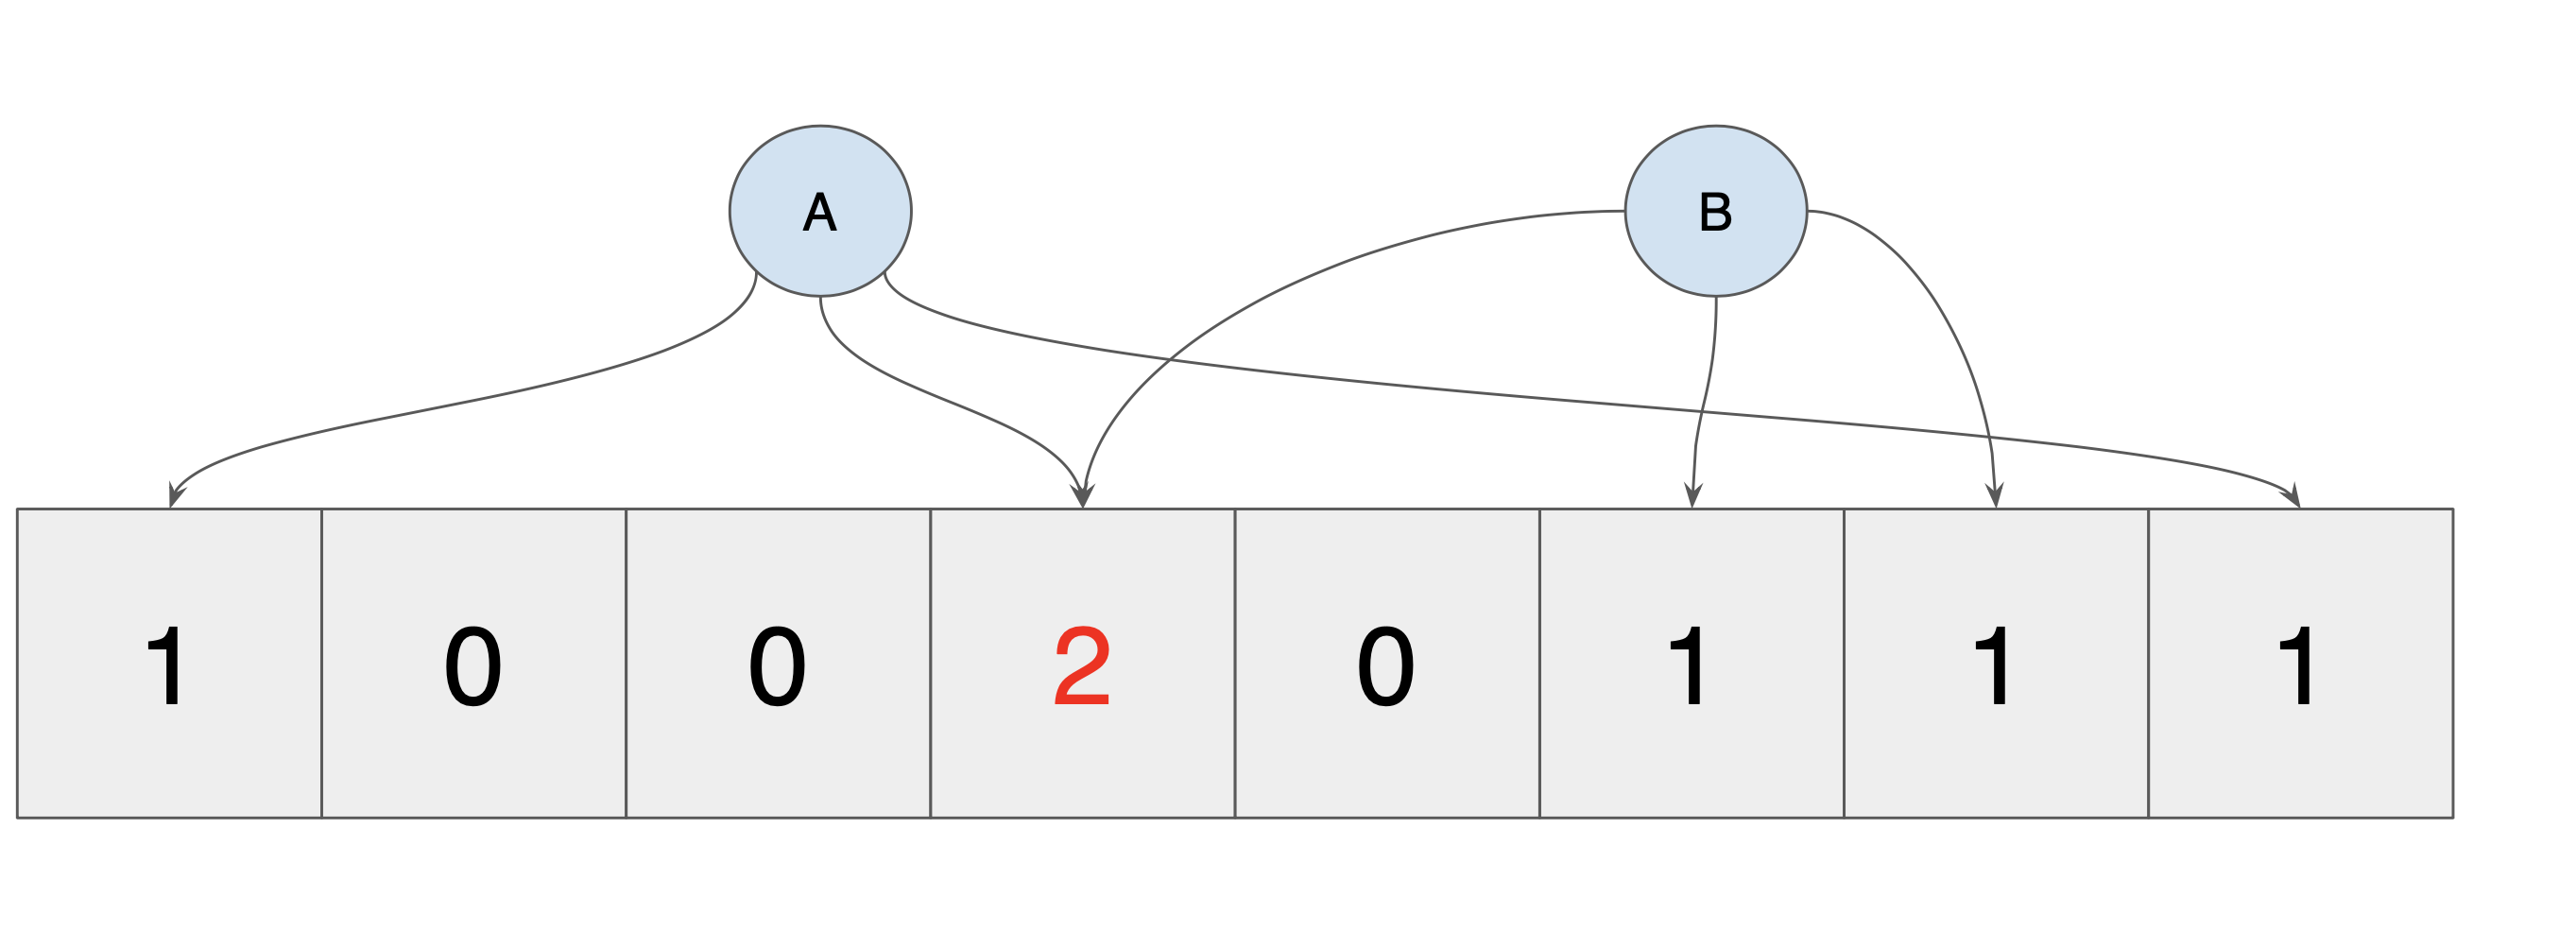

In [14]:
Image(filename='fourth.jpg')

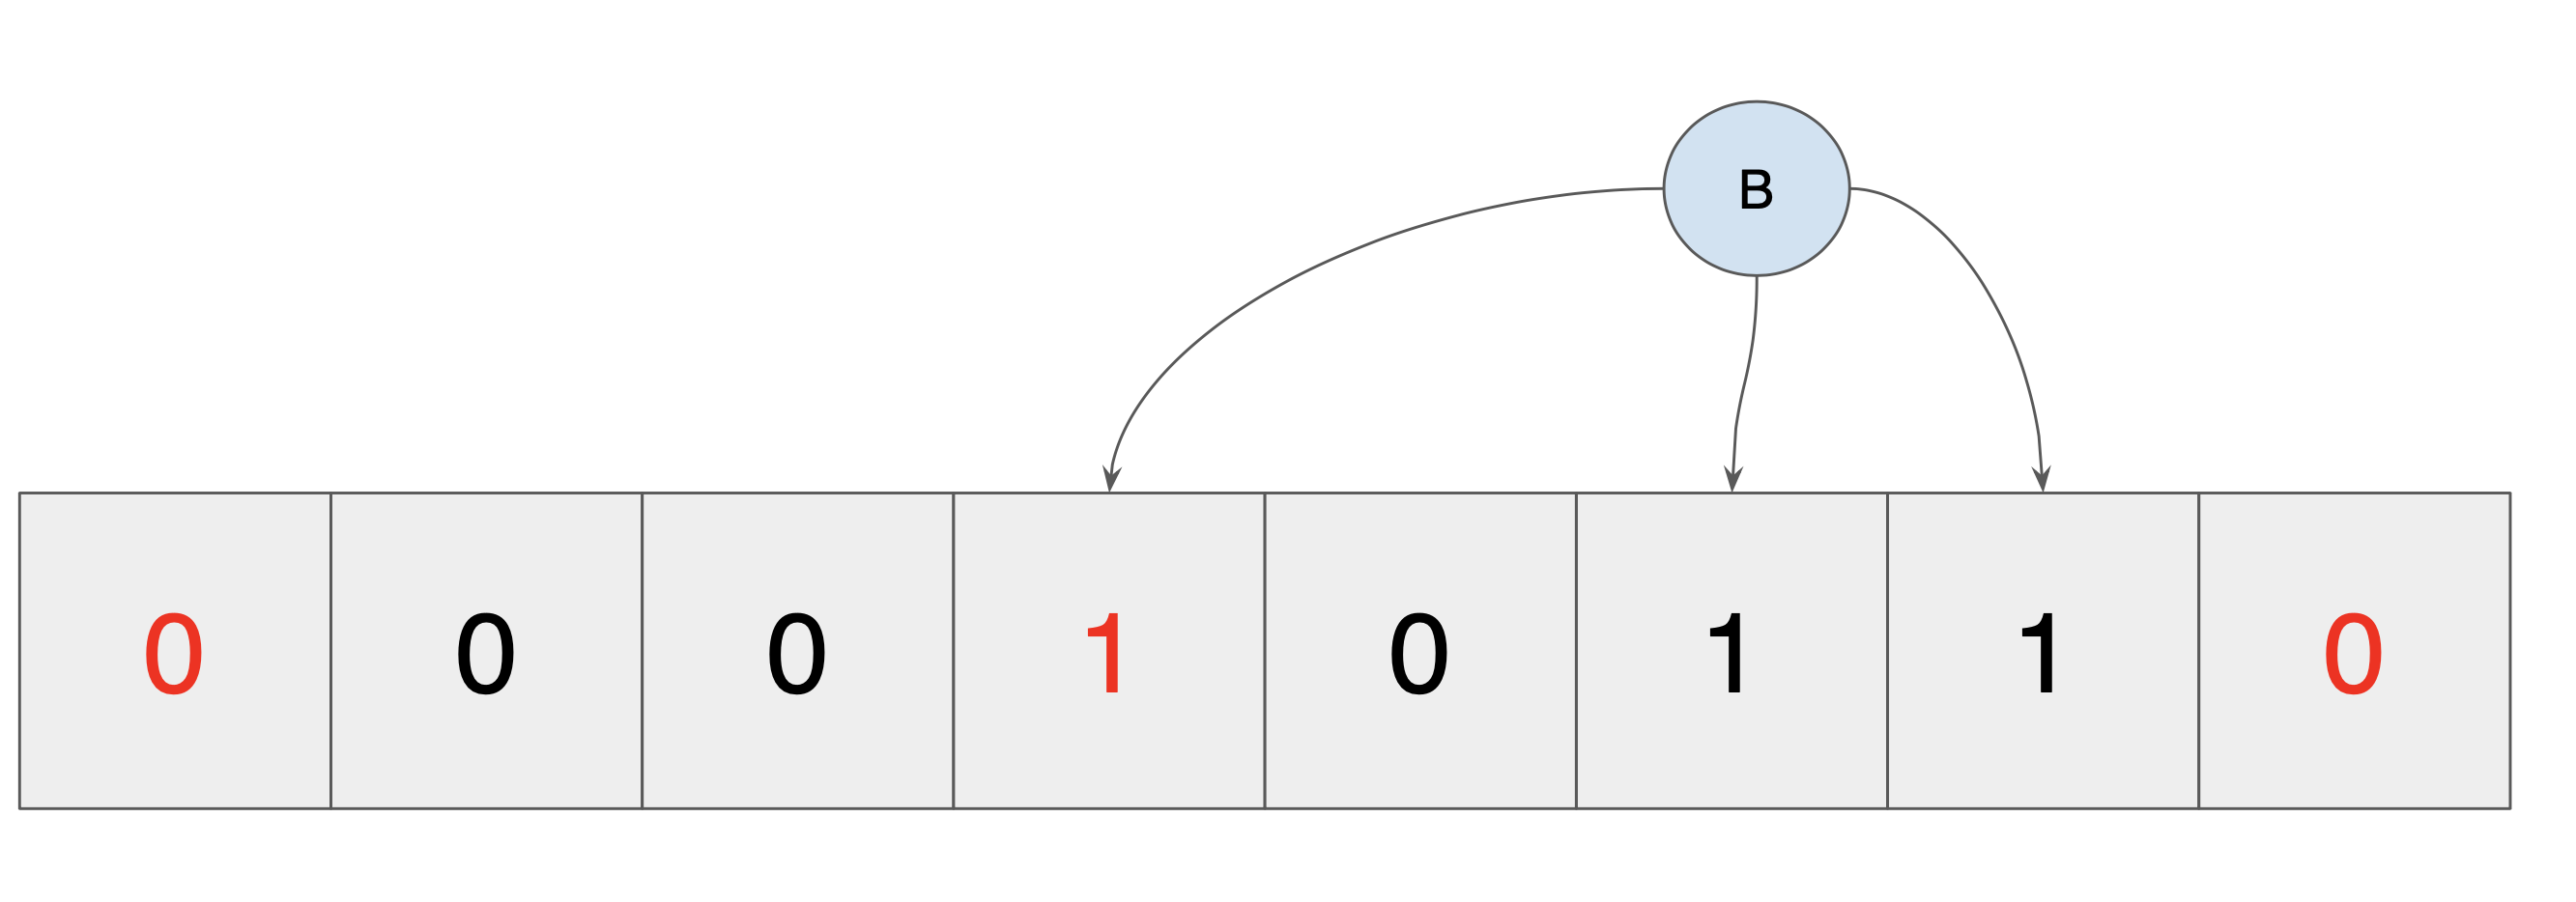

In [586]:
Image(filename='fith.jpg')

In this way, we are able to delete an element without effecting another element. This seems to be a big improvement from the traditional bloom filter!


### Applications 

- **Medium:** This blog site uses Bloom Filters in its article recommendation system. Bloom filters are useful since they can recommend an article *definitely not* in the set of articles read by a user to avoid annoying the user by redundant recommendations. Counting bloom filters can be used to delete articles marked as read that were simply opened. If the user was not on the site for the estimated reading time, they probably did not read it and the entry can be deleted and marked as unread. In fact, this may be very useful because being able to recommend an article that was opened but not read can encourage a user to actually read it! (or this can just be annoying if you did not like the topic) (Wikipedia, 2019).


- **Weak Passwords:** Large companies who protect users data have created huge lists of weak passwords such as $mypassword123$ and like to alert their customers if they are setting a weak password, so that they can increase their password strength and avoid being hacked. When a password is entered, it is hashed by the respective hash functions and the slots in the bloom filter are identified. If all of these slots are non zero, it is possibly a weak password and the user is alerted (Hassan, 2017). Counting bloom filters can be used if a weak password needs to be removed (perhaps over time it will no longer be weak, or perhaps it was put there by mistake). This is done by decrementing each slot pointed to by the hash functions. This will not delete other weak passwords, as the counting bloom filter has incrememted the slot for *each* weak password.


**Implement your own CBF data structure and required hash functions using Python, justifying why you’ve chosen them.**

In [486]:
#IMPORT RELEVANT LIBRARIES
from bitarray import bitarray 
import random
import string
import matplotlib.pyplot as plt
import time 
import numpy as np

#COUNTING BLOOM FILTER CLASS 
class CBF(object):
    
    #initialise
    #m is length of of bit array
    #k is number of hash functions we chose 4
    def __init__(self,m):
        self.array = [0]*m
        
    # 4 HASH FUNCTIONS
    #from class 7.2
    def hash_str1(self,string):
        ans = 0
        for chr in string:
            ans += ord(chr)
        return ans%len(self.array)

    def hash_str2(self,string):
        ans = 0
        for chr in string:
            ans = (ans ^ ord(chr))
        return ans%len(self.array)

    def hash_str3(self,string):
        ans = 0
        for chr in string:
            ans = ans * 128 + ord(chr)
        return ans%len(self.array)

    def hash_str4(self,string):
        random.seed(ord(string[0]))
        return random.getrandbits(32)%len(self.array)
    
    #FUNCTION TO ADD TO BLOOM FILTER
    def add(self, item):
        function_array = [self.hash_str1,self.hash_str2,self.hash_str3,self.hash_str4]
        #iterate through hash functions 
        for function in function_array:
            #incrememnt the index slot by 1
            self.array[function(item)]+=1
            
    
    #FUNCTION TO CHECK IF ELEMENT IS LIKELY IN THE BLOOM FILTER
    def query(self, item):
        
        function_array = [self.hash_str1,self.hash_str2,self.hash_str3,self.hash_str4]
        
        #for each hash function
        #check if the hash key given by hash function has been mapped to before
        #ie check if it is not zero
        #if all are not zero
        #then it is likely in the set 
        for function in function_array:
            if self.array[function(item)] == 0:
                return False
            else:
                return True
        return self.array
    
    #FUNCTION TO REMOVE AN ITEM FROM THE BLOOM FILTER
    def remove(self, item):
        function_array = [self.hash_str1,self.hash_str2,self.hash_str3,self.hash_str4]
        #for all the indexes the hash functions point to:
        #decrement that place by 1
        #to remove the element 
        #this will not delete other elements because the counter
        #incrememted once for EACH item added
        
        for function in function_array:
            self.array[function(item)]-=1
        return self.array

In this class, I have used 4 hash functions. I chose to use more than 1 hash function, because with 1 hash function, there is a possibility of clustering of hash keys, resulting in many collisions, and hence more false positives. Increasing the number of hash functions thus reduces the number of false positives. (I will explain the math in the next cell)

The 4 hash functions chosen as the 4 from class which show linear, quadratic, double hash, and random methods. Although not all hash functions are the most effective (ie quadratic hashing leads to less collisions than linear hashing) I wanted to use a variety of hash functions to show a general behaviour of a counting bloom filter.

#### Variables

- $m$ is the memory of the bloom filter (ie the number of slots)
- $n$ is the number of items added to the bloom filter
- $k$ is the number of hash functions
- $\alpha$ is the false positive rate 

**Theoretical False Positive Rate**

Consider a particular location in the hash table, $j$.

The probability that the $i^{th}$ hash function does *not* map to $j$ is simply $1-$ $\frac{1}{m}$

Next, we can consider the probability that the bit called $j$ is not mapped by $any$ of the hash functions to be $(1-$ $\frac{1}{m}$$)^{kn}$ since $km$ represents the number of *tries* we had to succeed.

Now, we want to simplify this a bit, so we can use this equation for the definition of  $\frac{1}{e}$:

$(1-$ $\frac{1}{m}$$)^{m}$ = $\frac{1}{e}$ = $e^{-1}$

Now, we can insert $(1-$ $\frac{1}{m}$$)^{m}$ into our equation for the probability that bit $j$ is not set, by manipulating our exponent to simplify the equation:

$((1-$ $\frac{1}{m}$$)^{m})^{kn/m})$ = $(e^{-1})^{kn/m}$ = $e^{-kn/m}$

We get a false positive when all of the $k$ bits of a new element are already non zero such that:

$\alpha = (1-e^{-kn/m})^{k}$

As we can see, if we increase k from 1 to 4, we will decrease our false positive rate. Finding an optimal value for k is important and an exact value can be found with more mathematical manipulations, but for this introduction, I have chosen to use 4!

**Using your own Python implementation and generating data to push into the CBF, provide an analysis, both theoretical and experimental, of how your implementation scales in terms of:**


### a. memory size as a function of the false positive rate

#### Theoretical

given the same input sizeIt is known that a larger bloom filter will have less collisions than a smaller bloom filter and therefore there will be less false positives as these are largely caused by collisions,

Therefore, choosing a good memory size can help reduce collisions and decrease our false positive rate (Hassan, 2017).

The memory needed increases as a function of the false positive rate such that: $\alpha$ = $\frac{n}{m}$ (Foulger, 2017).

Therefore, for a fixed input size of $n$ we expect the false positive rate to scale according to a fraction of $m$ such that:

$\alpha = \frac{1}{m}$

#### Experimental

The graph below demonstrates the application of the theory described above. For false positive rates close to 1, we observe a small memory size, and visa verse. The shape of the graph demonstrates the relationship described above of $\frac{1}{m}$

*Note this plot also answers question 4*

In [487]:
#to get false positive rate, create a list of 1000 
#unique 10 letter words
#split into 500 and 500
#add 500 of them to the bloom filter
#test the other 500
#number of positives/500 is the false positive rate
#plot this for varying inputs of m

#function to generate random words of given length
def rand_word(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

#function to create some amount random words of length l
#store half in one vector, the other half in another vector
def create_words(amount, storage1, storage2,l):
    for i in range(0,amount//2):
        storage1.append(rand_word(l))
    for i in range(amount//2, amount):
        storage2.append(rand_word(l))


In [488]:
cbf = CBF(100000)

#FUNCTION TO CALCULATE FALSE POSITIVE RATE 
def false_positives(add, test, mem):
    
    #Add half of the words to the filter
    for word in add:
        cbf = CBF(mem)
        cbf.add(word)

    counter = 0
    
    #test if the words NOT added are in the filter
    #if they are this is a false positive
    for aword in test:
        if cbf.query(aword) == True:
            counter +=1

    return counter/len(test)

In [537]:
#FUNCTION TO STORE FALSE POSITIVES WITH CHANGING MEMORY SIZE 
def false_pos_vs_mem(high, add,test,x,y):
    
    #change memory size and compute false positives
    for mem in range(1,high,5):
        cbf = CBF(mem)
        y.append(mem)
        x.append(false_positives(add,test,mem))   

In [538]:
#FUNCTION TO MAKE A LINE PLOT
def make_plot(x,y,xlab,ylab, tit):
    plt.plot(x,y)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit)
    return plt.show()

In [582]:
add1 = []
test1 = []
create_words(1000,add1, test1, 10)

In [540]:
x1=[]
y1=[]
false_pos_vs_mem(500,add1,test1,x1,y1)

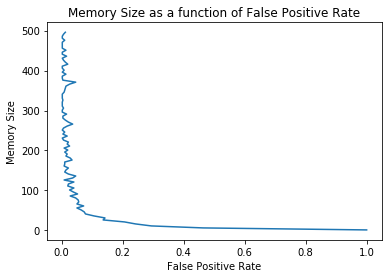

In [541]:
make_plot(x1,y1, 'False Positive Rate','Memory Size', 'Memory Size as a function of False Positive Rate')

### b. memory size as a function of the number of items stored

#### Theoretical 

The memory size needed stays the same despite the changing number of items stored since the bit array you create does not change after you have created it (Foulger, 2017).

#### Experimental 

Experimentally we can see that adding more items does not change the memory size of the bloom filter, which makes sense since there is not functionality added in my function for rescaling table size with elements added.

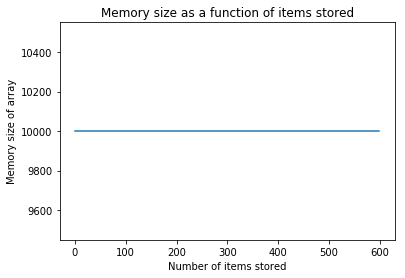

In [369]:
#memory size as a function of the number of items stored
#y axis will be memory size m
#x axis will be number of items stored
#we will have to change how many items we add items to a given memory

def m_vs_n(x,y, m, num_items_stored):
    for n in range(num_items_stored):
        #store the number of items added
        x.append(n)
        #add item
        cbf.add(test1[n])
        #store memory size
        y.append(m)
x3 = []  
y3 = []
m_vs_n(x3,y3, 10000, 600)
make_plot(x3,y3, 'Number of items stored', 'Memory size of array', 'Memory size as a function of items stored')

### c. access time as a function of the false positive rate

#### Theoretical

The access time for a bloom filter will be constant, and not dependent on the number of items stored or the memory size. This is because for each query, we will need to use the hash functions, which take constant time to find a slot (see explanation in question below). Therefore, no matter the false positive rate, the query time will be the same. False positive rates  decrease with an increase in memory size (as seen in question a), however, this change cannot be seen with constant query time.

#### Experimental

The graph below shows the constant query time with respect to changing false positive rates. There are slight fluctuations in the beginning due to Python's difficulty in recording small times. Nevertheless, the horizontal line trend is evident.

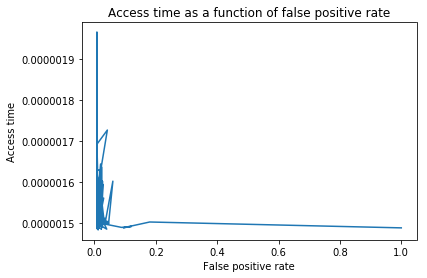

In [584]:
#modified from function above
def false_pos_vs_mem(high, add,test,x,y):
    for mem in range(1,high+1,10):
        cbf = CBF(mem)
        y.append(mem)
        x.append(false_positives(add,test,mem))   
        
x10 = []
y10 = []
false_pos_vs_mem(1000, add1,test1,x10,y10)

#function to time how long it takes to query an item
def time_query(item):
    start_time = time.time()
    cbf.query(item)
    return (time.time() - start_time)

#function to compute varying access times with changing memory size
def time_vs_m(x,y, aword, m):
    for mem in range(1,m+1,10):
        runtimes =[]
        cbf = CBF(mem)
        #store the number of items added
        x.append(mem)
        #get mean of runtime and store in y
        for j in range(1000):
            runtimes.append(time_query(aword))
        y.append(np.mean(runtimes))
x11 = []
y11 = []
time_vs_m(x11,y11, 'helloworld', 1000)

make_plot(x10,y11, 'False positive rate', 'Access time', 'Access time as a function of false positive rate')

### d. access time as a function of the number of items stored

#### Theoretical

The time taken to access a key remains the same despite an increase in the number of elements stored.

This is because the hash functions used have a constant runtime. Using 4 hash functions in our counting bloom filter means that to query an element, we will need to use 4 hash functions to point to 4 slots and check them. 

Time for 1 hash function query:

$O(1)$

Time for 4 hash function queries:

$O(1)*4 = O(4) $

Therefore, with constant memory size, lookup time should not change even with changing number of items stored.

#### Experimental

The plot below demonstrates how the access time remains constant despite the number of items which have been added to the counting bloom filter. Anonalies in computation cause a few spikes, but we have taken the mean of 5 access times to attempt to curb this which has resulted in a fairly constant lookup time.

In [320]:
#time the query function with different number of items stored 
#access time is y axis
#number of items stored is x axis

#function to store mean of query time and number of items stored
def time_vs_n(x,y, aword, num_items_stored):
    for n in range(num_items_stored):
        runtimes =[]
        
        #store the number of items added
        x.append(n)
        #add item
        cbf.add(test1[n])
        
        #get mean of runtime and store in y
        for j in range(5):
            runtimes.append(time_query(aword))
        y.append(np.mean(runtimes))

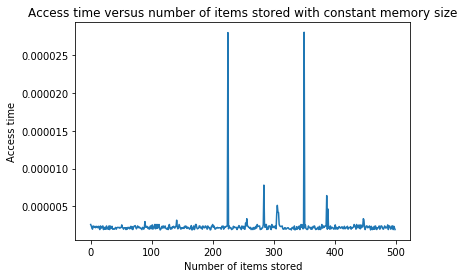

In [321]:
#MAKE PLOT 
cbf = CBF(10000)
time_query('ascds')
x5 = []
y5 = []
time_vs_n(x5,y5,'abcdef',500)
make_plot(x5,y5,'Number of items stored','Access time', 'Access time versus number of items stored with constant memory size')

**Enumerate (if any) corner cases that one might find in CBFs.**

#### Corner Cases 

A corner case is an extreme case. In a Counting Bloom Filter, an extreme case could be:

1) If memory size is very large. In this case, we have a lower probability of false positives given the same input size since $\alpha$ increases as a function of $\frac{n}{m}$

2) If memory size is very small, we will have a very high chance of collisions and hence of false positives, for example considering a bloom filter of length 1, all items will hash to this slot, and no matter which item we query, we will receive a positive.

## HCs

**#evidencebased:** For each theoretical explanation I gave, I included an experimental implementation of the graph. In this way, I could back up my claims with visual evidence, which is compelling in convincing myself and the reader of this paper that my interpretations are correct.

**#utility:** When making the decision whether or not to take an extension on this assignment, I considered the costs and benefits for all stakeholders - myself, Professor Drummond, and my flatmates. I knew that submitting the assignment on time would be nice to have it off my hands but I also knew the assignment was not of the best quality. This drawback would also be present for Prof Drummond as he would have to grade a bad assignment and may get frustrated. Considering my flatmates, they would have to deal with my stress for another day should I take an extension, or deal with my bad mood when I got bad grades should I not have taken an extension. In considering maximising utility for all stakeholders, it seemed most logical to take an extension, submit good work, and make everyone happier in the longrun.

**#testability:** Conducts many experimental tests to demonstrate how the theory of Bloom Filters can be tested. For each graph I made, I first had to determine whether my theory, or 'hypothesis', was testable, and then attempt to implement these tests in code.

**#probability:** I calculated the probability of false positives and used data visualisations to be able to visually see how they changed with regards to memory and access time. Not only did I have to have mathematical knowledge of probability to do this, but I had to understand the mechanisms that *changed* these probabilities.

## References

Foulger, R. (2017, March 05). Bloom Filters - CS110. Retrieved March 10, 2019, from https://www.youtube.com/watch?v=ftD9ncFr97w

Freund, Y. (2012, May 16). Bloom Filters. Retrieved March 10, 2019, from https://www.youtube.com/watch?v=bEmBh1HtYrw

Geeks for Geeks. (2018, February 08). Bloom Filters - Introduction and Python Implementation. Retrieved March 10, 2019, from https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/

Hassan. (2017, December 09). Probabilistic Data structures: Bloom filter. Retrieved March 10, 2019, from https://hackernoon.com/probabilistic-data-structures-bloom-filter-5374112a7832

University of Texas. (2017). Bloom Filters. Retrieved March 10, 2019, from http://www.cs.utexas.edu/users/lam/396m/slides/Bloom_filters.pdf

Wikipedia. (2019, February 04). Bloom filter. Retrieved March 10, 2019, from https://en.wikipedia.org/wiki/Bloom_filter#Counting_filter